# Visualising taxa abundance

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)
require(compositions)
require(ggpubr)
require(see)
require(doParallel)
require(Rtsne)
require(vegan)
require(VennDiagram)
require(vegan)
require(ape)
registerDoParallel(cores=8)

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required packag

## Pre-process data

### Load and parse data

In [2]:
get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


load_data <- function(file_path) {
    df <- fread(file_path) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(df)
}


In [3]:
rank <- "S"
n_subset <- 9999

to_retain <- fread("data/samples_above_100_microbial_reads.txt")$npm_research_id

meta <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv") %>%
    filter(npm_research_id %in% to_retain)

meta_cols <- get_meta_cols(meta)

species_df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.{rank}.tsv")) %>%
    filter(npm_research_id %in% to_retain) %>%
    select(-unclassified, -"Homo sapiens")

prev_df <- fread("results/decontamination/prevalence_RA0.01_read10.csv")

#### Load non-contaminant list

In [4]:
# Differential prevalence
diff_prev_nc <- read.csv("results/decontamination/diff_prev_V3/noncontaminants.RA0.01.read_threshold10.max_prev0.25.fold_diff2.txt")$taxa
diff_prev_c <- read.csv("results/decontamination/diff_prev_V3/contaminants.RA0.01.read_threshold10.max_prev0.25.fold_diff2.txt")$taxa
length(diff_prev_nc)
length(diff_prev_c)

# Correlation filter
corr_nc <- read.csv("results/decontamination/correlation_decontamination/nc.diff_prev_V3.RA0.01.read_threshold10.max_prev0.25.fold_diff2.corr_t0.7.S.n9999.txt")$non_contaminant_taxon
corr_c <- read.csv("results/decontamination/correlation_decontamination/contam.diff_prev_V3.RA0.01.read_threshold10.max_prev0.25.fold_diff2.corr_t0.7.S.n9999.txt")$contaminant

length(corr_nc)
length(corr_c)

# Simple batch filter
batch_nc <- read.csv("results/decontamination/simple_batch_decontam/nc.txt")$taxa
length(batch_nc)

[1] 478

[1] 86

[1] 434

[1] 44

[1] 176

### Set 'absent' taxa to zero

In [5]:
species_zeroed <- species_df %>% 
    select(all_of(colnames(prev_df))) %>%
    column_to_rownames("npm_research_id")

prev_bool_df <- prev_df %>%
    column_to_rownames("npm_research_id")

for(i in seq(ncol(species_zeroed))) {
    species_zeroed[!prev_bool_df[, i], i] <- 0
}

species_filt <- species_zeroed %>% 
    rownames_to_column("npm_research_id") %>%
    select(all_of(c("npm_research_id", batch_nc)))

#### Relative abundance

In [6]:
otu_to_RA <- function(df) {
    row_names <- df$npm_research_id
    RA_df <- t(apply(df[, 2:ncol(df)], 1, function(x) {x / sum(x)}))
    
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(RA_df, check.names = F)))
}

species_filt_RA <- otu_to_RA(species_filt)

#### CLR transform

In [7]:
RA_to_clr <- function(df) {
    row_names <- df$npm_research_id
    clr_df <- clr(df %>% select(where(is.numeric)))
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(clr_df, check.names = F)))
}

# species_clr <- RA_to_clr(species_RA)
# head(species_clr)

### Summary stats of non-contaminants

#### Max read count

In [8]:
max_df <- species_filt %>% 
    select(-npm_research_id) %>%
    pivot_longer(everything(), names_to = "taxa", values_to = "read_count") %>%
    group_by(taxa) %>%
    summarise(max_count = max(read_count)) %>%
    arrange(desc(max_count))

#### Overall prevalence

In [9]:
prev_stats <- apply(prev_df[, 2:ncol(prev_df)], 2, sum) / nrow(prev_df)
overall_prev <- data.frame(taxa = names(prev_stats), overall_prevalence = as.vector(prev_stats))

In [10]:
prev_max <- max_df %>%
    left_join(overall_prev) %>%
    arrange(desc(overall_prevalence)) %>%
    mutate(n_samples = overall_prevalence * nrow(prev_df),
           max_bin = case_when(max_count < 10 ~ "<10",
                               max_count >= 10 & max_count < 50 ~ "10-50",
                               max_count >= 50 & max_count < 100 ~ "50-100",
                               max_count >= 100 & max_count < 500 ~"100-500",
                               max_count >= 500 ~">=500")) %>%
    mutate(max_bin = factor(max_bin, levels = c("<10", "10-50", "50-100", "100-500", ">=500"))) %>%
    arrange(desc(overall_prevalence))
prev_max

Joining, by = "taxa"



taxa,max_count,overall_prevalence,n_samples,max_bin
<chr>,<dbl>,<dbl>,<dbl>,<fct>
Cutibacterium acnes,22588,0.033886503,292,>=500
Mitsuaria sp. 7,953,0.026807474,231,>=500
Microbacterium hominis,19410,0.021121040,182,>=500
Microbacterium sp. PM5,82819,0.019264245,166,>=500
Bacillus cereus,39574,0.017059301,147,>=500
Moraxella osloensis,2378,0.016711152,144,>=500
Burkholderia contaminans,46034,0.015434606,133,>=500
Human mastadenovirus C,17476,0.014738308,127,>=500
Microbacterium sp. Y-01,65436,0.013113613,113,>=500


#### Max count filter

In [11]:
prev_max_filt <- prev_max %>% filter(max_count > 100)
prev_max_filt 
fwrite(prev_max_filt, "results/decontamination/global_decontamination_stats.csv")

taxa,max_count,overall_prevalence,n_samples,max_bin
<chr>,<dbl>,<dbl>,<dbl>,<fct>
Cutibacterium acnes,22588,0.033886503,292,>=500
Mitsuaria sp. 7,953,0.026807474,231,>=500
Microbacterium hominis,19410,0.021121040,182,>=500
Microbacterium sp. PM5,82819,0.019264245,166,>=500
Bacillus cereus,39574,0.017059301,147,>=500
Moraxella osloensis,2378,0.016711152,144,>=500
Burkholderia contaminans,46034,0.015434606,133,>=500
Human mastadenovirus C,17476,0.014738308,127,>=500
Microbacterium sp. Y-01,65436,0.013113613,113,>=500


### Save decontaminated data

In [25]:
species_read_final %>%
             filter(npm_research_id %in% non_zero_rows)

npm_research_id,Cutibacterium acnes,Mitsuaria sp. 7,Microbacterium hominis,Microbacterium sp. PM5,Bacillus cereus,Moraxella osloensis,Burkholderia contaminans,Human mastadenovirus C,Microbacterium sp. Y-01,⋯,Corynebacterium aurimucosum,Deinococcus actinosclerus,Deinococcus swuensis,Torque teno virus 6,Deinococcus ficus,Roseomonas gilardii,Agrobacterium fabrum,Dermacoccus nishinomiyaensis,Torque teno virus 21,Deinococcus irradiatisoli
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WHB669,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
WHB8678,0,0,0,416,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
WHH7080,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
WHB4818,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
WHB9470,0,167,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
WHB4637,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
WHB3974,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
WHB7065,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
WHB8830,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [31]:
species_read_final <- species_filt %>%
    select(all_of(c("npm_research_id", prev_max_filt$taxa)))

fwrite(species_read_final, "results/decontamination/read_matrix_n125.global_decontaminated.zeroed.csv")

# Remove zero rows
non_zero_rows <- species_read_final$npm_research_id[rowSums(species_read_final %>% select(-npm_research_id)) != 0]
otu_to_RA(species_read_final %>% filter(npm_research_id %in% non_zero_rows)) %>%
    fwrite("results/decontamination/RA_matrix_n125.global_decontaminated.zeroed.csv")

#### Compare with fine grain analysis

In [12]:
global_not_fine <- read.csv("results/decontamination/global_not_fine_taxa.txt")$taxa
length(global_not_fine)
prev_max_filt %>% 
    filter(taxa %in% global_not_fine) %>%
    separate(taxa, sep = " ", into = c("genus", "species")) %>%
    group_by(genus) %>%
    summarise(n = n()) %>%
    arrange(desc(n))

[1] 5

Warning message:
“Expected 2 pieces. Additional pieces discarded in 1 rows [2].”


genus,n
<chr>,<int>
Microbacterium,3
Burkholderia,1
Pannonibacter,1


### Rank species by prevalence and max read count

In [13]:
top_max_count <- prev_max_filt %>% 
    arrange(desc(max_count)) %>% 
    mutate(count_rank = seq(nrow(prev_max_filt)))

top_prev <- prev_max_filt %>% 
    arrange(desc(overall_prevalence)) %>%
    mutate(prev_rank = seq(nrow(prev_max_filt)))

top_max_count %>% 
    full_join(top_prev) %>%
    mutate(ranksum = count_rank + prev_rank) %>%
    arrange(prev_rank)

Joining, by = c("taxa", "max_count", "overall_prevalence", "n_samples", "max_bin")



taxa,max_count,overall_prevalence,n_samples,max_bin,count_rank,prev_rank,ranksum
<chr>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>
Cutibacterium acnes,22588,0.033886503,292,>=500,10,1,11
Mitsuaria sp. 7,953,0.026807474,231,>=500,47,2,49
Microbacterium hominis,19410,0.021121040,182,>=500,12,3,15
Microbacterium sp. PM5,82819,0.019264245,166,>=500,3,4,7
Bacillus cereus,39574,0.017059301,147,>=500,8,5,13
Moraxella osloensis,2378,0.016711152,144,>=500,33,6,39
Burkholderia contaminans,46034,0.015434606,133,>=500,7,7,14
Human mastadenovirus C,17476,0.014738308,127,>=500,13,8,21
Microbacterium sp. Y-01,65436,0.013113613,113,>=500,5,9,14


### Get samples with max. read counts

#### Get metadata of top 20 bacterial taxa ranked by max count

In [14]:
top_20 <- top_max_count %>%
    filter(!grepl("Human", taxa)) %>%
    select(taxa, max_count, overall_prevalence, n_samples) %>%
    head(20)

morsels <- foreach (i = seq(nrow(top_20))) %do% {
    row <- top_20[i, ]
    taxon <- row$taxa
    max_count <- row$max_count
    sample_with_max_count <- (species_filt %>% filter(get(taxon) == max_count))$npm_research_id
    
    RA <- species_filt_RA %>% 
        filter(npm_research_id == sample_with_max_count) %>%
        select(all_of(taxon))
    RA <- deframe(RA)
    
    row$max_sample <- sample_with_max_count
    row$rel_a <- RA
    
    return(row)
}

top_20_parsed <- bind_rows(morsels)

top_20_parsed

fwrite(top_20_parsed, "results/irep_analysis/global_top_20_bacteria_max_count.csv")

taxa,max_count,overall_prevalence,n_samples,max_sample,rel_a
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Fusobacterium nucleatum,194777,0.001044447,9,WHB4594,0.97606162
Paracoccus yeei,85304,0.003133341,27,WHH1680,0.98837869
Microbacterium sp. PM5,82819,0.019264245,166,WHB10821,0.51773848
Staphylococcus haemolyticus,79966,0.010560520,91,0416-0024,0.60186356
Microbacterium sp. Y-01,65436,0.013113613,113,WHB3375,0.59195064
Staphylococcus cohnii,52898,0.009516073,82,0416-0024,0.39813644
Burkholderia contaminans,46034,0.015434606,133,WHB10821,0.28777905
Bacillus cereus,39574,0.017059301,147,WHH5104,1.00000000
Microbacterium sp. PAMC 28756,24529,0.003829639,33,WHB3375,0.22189555


[1] "WHB10821"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 8451 rows containing non-finite values (stat_bin).”


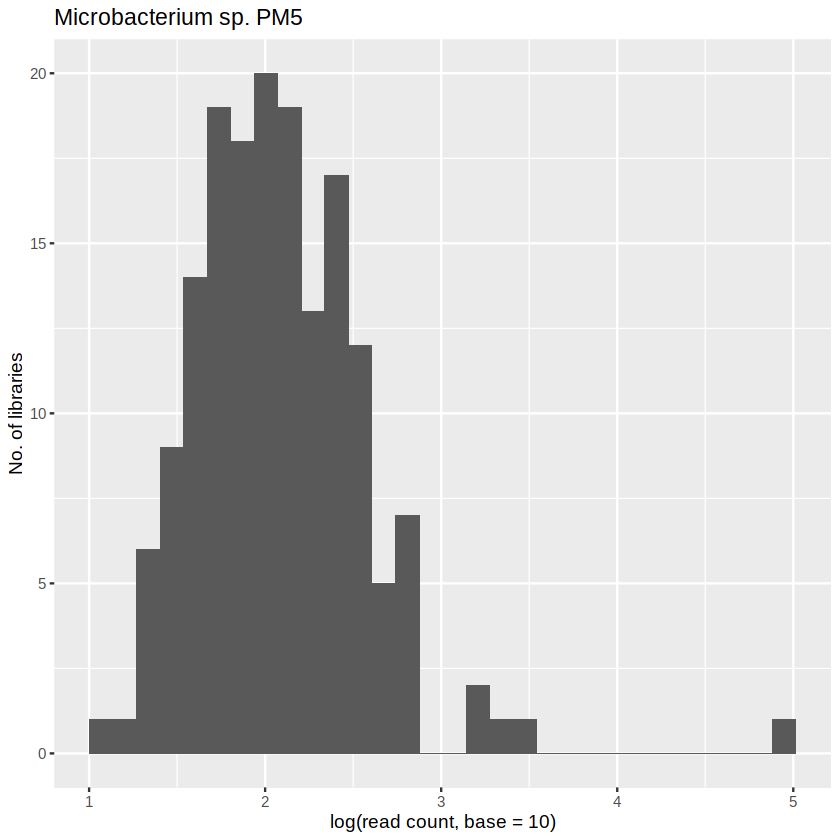

In [15]:
# taxon <- "Paracoccus yeei"
# taxon <- "Fusobacterium nucleatum"
# taxon <- "Cutibacterium acnes"
# taxon <- "Bacillus cereus"
taxon <- "Burkholderia contaminans"
# taxon <- "Microbacterium hominis"
taxon <- "Microbacterium sp. PM5"
max_count <- prev_max_filt[prev_max_filt$taxa == taxon, ]$max_count
id <- (species_filt %>%
    filter(get(taxon) == max_count))$npm_research_id
print(id)

# species_RA %>% 
#     filter(npm_research_id == id) %>%
#     select(all_of(c(taxon)))

species_filt %>%
    select(all_of(c("npm_research_id", taxon))) %>%
    arrange(desc(get(taxon))) %>%
#     filter(get(taxon) > 100) %>%
    ggplot(aes(x = log(get(taxon), base = 10))) +
    geom_histogram() +
    labs(x = "log(read count, base = 10)", y = "No. of libraries", title = taxon)

### No. of taxa per sample

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



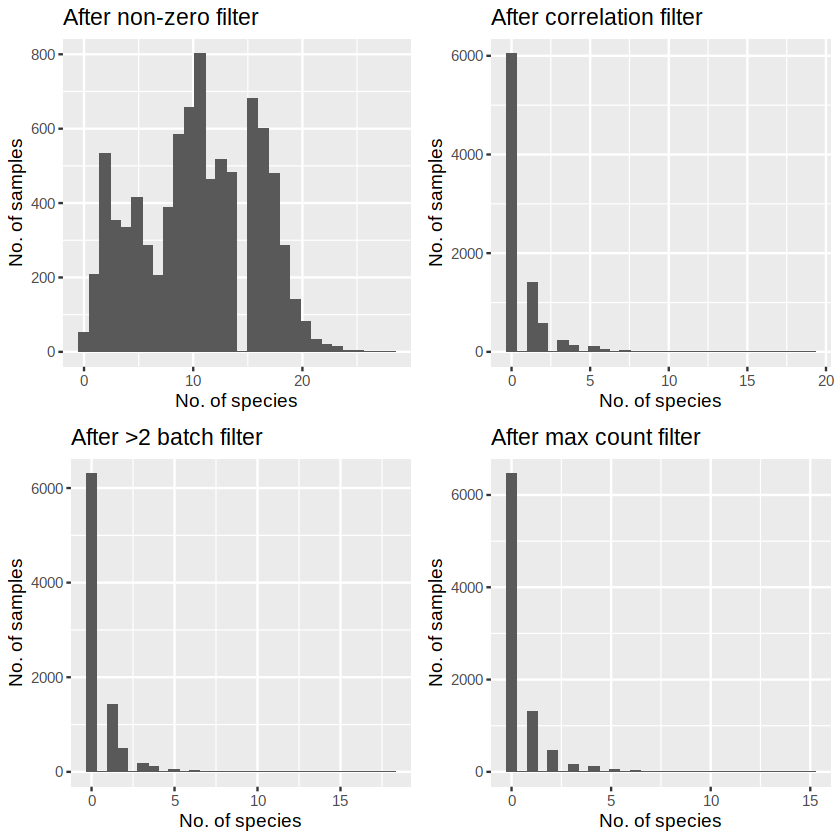

In [16]:
# After PA thresholding
tax_plt <- tibble(n = rowSums(prev_df %>% select(-npm_research_id))) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After non-zero filter")

# After correlation decontamination
species_prev_filt1 <- prev_df %>% select(all_of(corr_nc))
tax_plt1 <- tibble(n = rowSums(species_prev_filt1)) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After correlation filter")

# After simple batch filter
species_prev_filt2 <- prev_df %>% select(all_of(batch_nc))
tax_plt2 <- tibble(n = rowSums(species_prev_filt2)) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After >2 batch filter")


# After max count filter
species_prev_filt3 <- prev_df %>% select(all_of(prev_max_filt$taxa))
tax_plt3 <- tibble(n = rowSums(species_prev_filt3)) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After max count filter")

ggarrange(tax_plt, tax_plt1, tax_plt2, tax_plt3)

In [24]:
sum(rowSums(species_prev_filt3) == 0)

[1] 6456

### Sample clustering

In [66]:
prev_mat <- species_prev_filt3[rowSums(species_prev_filt3) != 0, ]

# Get Jaccard matrix
dist <- vegdist(as.matrix(prev_mat),  method = "jaccard")

# Run PCoA
PCOA <- pcoa(dist)

In [81]:
round(PCOA$values$Relative_eig, 3) * 100

[1]  9.5  7.8  6.8  6.0  5.7  5.0  4.5  4.1  3.9  3.8  3.4  3.2  3.1  2.4
  [15]  1.9  1.5  1.4  1.4  1.3  1.3  1.1  1.1  1.0  1.0  0.9  0.9  0.9  0.8
  [29]  0.8  0.7  0.7  0.6  0.6  0.6  0.5  0.5  0.5  0.5  0.4  0.4  0.4  0.4
  [43]  0.4  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.2  0.2  0.2
  [57]  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.1  0.1  0.1  0.1
  [71]  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  [85]  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.0  0.0
  [99]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [113]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [127]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [141]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [155]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [169]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [183]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [197]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [211]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [225]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [239]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [253]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [267]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [281]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [295]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [309]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [323]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [337]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [351]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [365]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [379]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [393]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [407]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [421]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [435]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [449]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [463]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [477]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [491]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [505]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [519]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [533]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [547]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [561]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [575]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [589]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [603]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [617]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [631]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [645]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [659]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [673]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [687]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [701]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 [715]  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

png 
  2

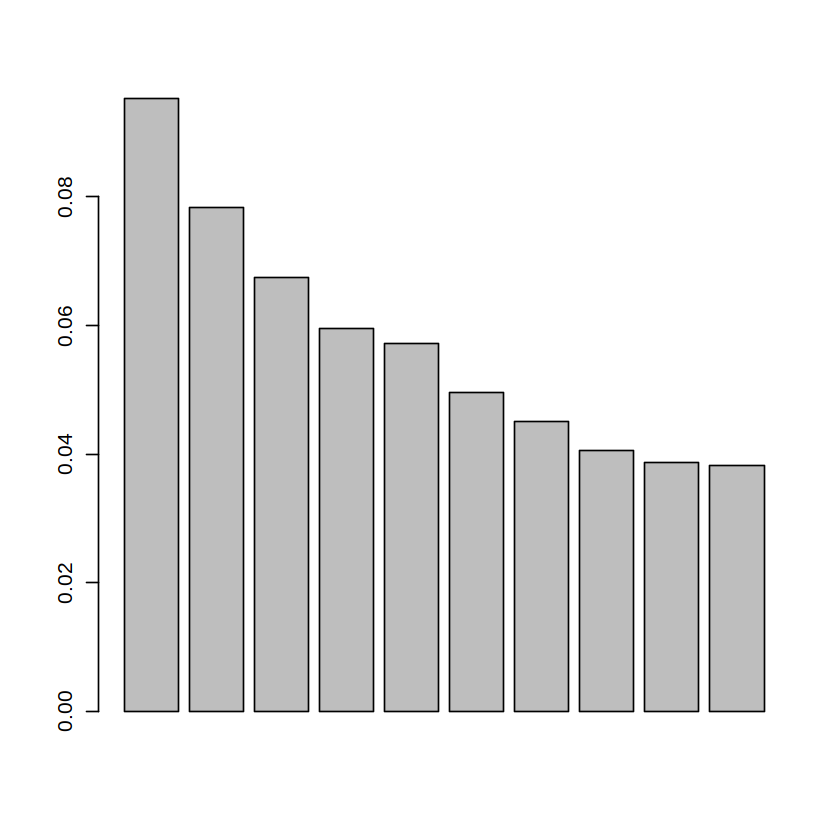

In [76]:
barplot(PCOA$values$Relative_eig[1:10])
# PCOA
# ggplot(as_tibble(pca$vectors), aes(x = Axis.1, y = Axis.2)) +
#     geom_point()

pdf("results/decontamination/global_decontamination_biplot.pdf", width = 10, height = 10)
biplot.pcoa(PCOA, prev_mat)
dev.off()

In [23]:
species_prev <- species_filt %>%
    select(all_of(batch_nc))


Achromobacter sp. AONIH1,Acidovorax sp. KKS102,Acinetobacter baumannii,Acinetobacter guillouiae,Acinetobacter haemolyticus,Acinetobacter junii,Acinetobacter pittii,Acinetobacter schindleri,Acinetobacter sp. ACNIH1,Acinetobacter sp. WCHA45,⋯,Streptococcus sp. ChDC B345,Streptococcus sp. oral taxon 431,Sulfuritalea hydrogenivorans,Torque teno virus 21,Torque teno virus 6,Variovorax paradoxus,Veillonella dispar,Veillonella parvula,Xanthomonas campestris,Zhihengliuella sp. ISTPL4
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,5,0,0,2,0
2,5,0,0,0,0,0,0,0,0,⋯,0,0,2,0,0,5,0,0,4,0
0,0,5,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,9,6,1,1,2,1,1,1,0,⋯,0,0,1,0,0,44,0,0,2,1
0,0,1,0,0,0,0,0,0,0,⋯,6,6,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,⋯,0,0,1,0,0,3,0,0,1,0
0,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
0,0,1,0,0,1,1,0,0,0,⋯,0,0,0,0,0,2,0,0,2,5


## Controls

In [79]:
species_prev %>%
    left_join(meta) %>%
    filter(get("Gardnerella vaginalis") & get("Lactobacillus crispatus")) %>%
    group_by(supplied_gender) %>%
    summarise(n = n())

Joining, by = "npm_research_id"



supplied_gender,n
<chr>,<int>
F,3
M,3


In [64]:
pos_control <- read.csv("data/reported_controls/damgaard_2015_positive.txt")$positive_controls
torque_tenos <- (overall_prev %>% filter(grepl("torque teno", taxa, ignore.case = T)))$taxa
herpes <- (overall_prev %>% filter(grepl("herpes", taxa, ignore.case = T)))$taxa
pos_control <- c(pos_control, 
                 "Escherichia coli",
                 "Pasteurella multocida", 
                 "Bartonella henselae", "Bartonella clarridgeiae", 
                 "Enterococcus faecalis", "Cutibacterium acnes", "Staphylococcus epidermis", "Actinomyces viscosus",
                 "Streptococcus agalactiae",
                 "Yersinia enterocolitica",
                 "Leclercia adecarboxylata",
                 "Streptococcus pneumoniae",
                 torque_tenos,
                 herpes
                 )
neg_control1 <- read.csv("data/reported_controls/asmp_parsed_negative.txt")$taxa
neg_control2 <- read.csv("data/reported_controls/chng_2020_parsed_negative.txt")$taxa
neg_control3 <- read.csv("data/reported_controls/caregiver_parsed_negative.txt")$taxa

intersection <- Reduce(intersect, list(neg_control1, neg_control2, neg_control3))
union <- unique(c(neg_control1, neg_control2, neg_control3))

# At least 2 studies
all_neg <- table(c(neg_control1, neg_control2, neg_control3))
semi_union <- names(all_neg[all_neg >= 2])

pos_not_intersect <- pos_control[!(pos_control %in% intersection)]
pos_not_union <- pos_control[!(pos_control %in% union)]
pos_not_semi <- pos_control[!(pos_control %in% semi_union)]

print(length(intersection))
print(length(union))
print(length(semi_union))
print(length(pos_control))
print(length(pos_not_intersect))
print(length(pos_not_union))

[1] 8
[1] 320
[1] 53
[1] 51
[1] 50
[1] 39


In [67]:
batch_nc[batch_nc %in% pos_not_semi]

[1] "Cutibacterium acnes"      "Cutibacterium granulosum"
[3] "Human betaherpesvirus 6A" "Human betaherpesvirus 6B"
[5] "Moraxella osloensis"      "Streptococcus pneumoniae"
[7] "Torque teno virus 21"     "Torque teno virus 6"

In [66]:
venn_list1 <- list(batch_nc = batch_nc,
                  pos_not_semi = pos_not_semi)

venn_list2 <- list(batch_nc = batch_nc,
                  semi_union = semi_union)


venn.diagram(venn_list1, 
             filename = str_glue("results/decontamination/simple_batch_decontam/decontamination_results_pos_controls.png"),
             category.names = c("", ""),
             print.mode = c("raw"),
             fill = c("#999999", "#E69F00")
             )

venn.diagram(venn_list2, 
             filename = str_glue("results/decontamination/simple_batch_decontam/decontamination_results_neg_controls.png"),
             category.names = c("", ""),
             print.mode = c("raw"),
             fill = c("#999999", "#E69F00")
             )

# filename = str_glue("results/decontamination/diff_prev_V3/decontamination_results_pos_controls.png"),

[1] 1

[1] 1

#### Venn diagrams

In [30]:
venn_list_nc <- list(non_zero, diff_prev_nc, diff_abn_nc, corr_nc)

# venn.diagram(venn_list_nc, filename = "results/decontamination/decontamination_methods_venn.png",
#              category.names = c("Non-zero species", "Diff. prevalence filter", "Diff. abundance filter"),
#              print.mode = c("raw", "percent"),
#              height = 5000,
#              width = 5000,
#              margin = 0.1,
#              cat.dist = 0.1,
#              cat.fontface = "bold"
#              )

venn.diagram(venn_list_nc[2:5], filename = "results/decontamination/decontamination_methods_venn.simple.png",
             category.names = c("Diff. prevalence filter", "Diff. abundance filter", "Corr. filter"),
             print.mode = c("raw", "percent"),
             height = 5000,
             width = 5000,
             margin = 0.1,
             cat.dist = 0.1,
             cat.fontface = "bold",
             fill = c("salmon", "#00bfc4", "#7cae00")
             )

[1] 1

In [55]:
diff_abn_nc[!(diff_abn_nc %in% diff_prev_nc)]

[1] "Methylocystis sp. SC2"        "Pseudonocardia dioxanivorans"

### Decontaminants X Positive/Negative controls

In [35]:
pos_control <- read.csv("data/reported_controls/damgaard_2015_positive.txt")$positive_controls
torque_tenos <- (overall_prev %>% filter(grepl("torque teno", taxa, ignore.case = T)))$taxa
herpes <- (overall_prev %>% filter(grepl("herpes", taxa, ignore.case = T)))$taxa
pos_control <- c(pos_control, 
                 "Escherichia coli",
                 "Pasteurella multocida", 
                 "Bartonella henselae", "Bartonella clarridgeiae", 
                 "Enterococcus faecalis", "Cutibacterium acnes", "Staphylococcus epidermis", "Actinomyces viscosus",
                 "Streptococcus agalactiae",
                 "Yersinia enterocolitica",
                 "Leclercia adecarboxylata",
                 "Streptococcus pneumoniae",
                 torque_tenos,
                 herpes
                 )
neg_control1 <- read.csv("data/reported_controls/asmp_parsed_negative.txt")$taxa
neg_control2 <- read.csv("data/reported_controls/chng_2020_parsed_negative.txt")$taxa
neg_control3 <- read.csv("data/reported_controls/caregiver_parsed_negative.txt")$taxa

neg_control <- unique(c(neg_control1, neg_control2, neg_control3))
neg_intersect <- Reduce(intersect, list(neg_control1, neg_control2, neg_control3))

In [42]:
venn_list_nc <- list(pos_control, neg_intersect, corr_nc)

venn.diagram(venn_list_nc, filename = "results/decontamination/all_filters_pos_neg_intersect_controls_venn.png",
             category.names = c("Positive controls", "Negative controls (intersect)", "After all filters"),
             print.mode = c("raw", "percent"),
             height = 5000,
             width = 5000,
             cat.fontface = "bold",
             fill = c("salmon", "#00bfc4", "#7cae00")
             )

venn_list_nc <- list(pos_control, neg_control, corr_nc)

venn.diagram(venn_list_nc, filename = "results/decontamination/all_filters_pos_neg_union_controls_venn.png",
             category.names = c("Positive controls", "Negative controls (union)", "After all filters"),
             print.mode = c("raw", "percent"),
             height = 5000,
             width = 5000,
             cat.fontface = "bold",
             fill = c("salmon", "#00bfc4", "#7cae00")
             )

[1] 1

[1] 1

In [44]:
intersect(pos_control, corr_nc)

[1] "Enterococcus faecalis"     "Torque teno mini virus 7" 
 [3] "Torque teno mini virus 18" "Torque teno mini virus 1" 
 [5] "Torque teno mini virus 3"  "Torque teno mini virus 5" 
 [7] "Torque teno virus 9"       "Torque teno virus 23"     
 [9] "Human betaherpesvirus 6B"  "Human betaherpesvirus 6A"

In [43]:
intersect(neg_control, corr_nc)
intersect(neg_intersect, corr_nc)

[1] "Streptococcus vestibularis"                    
 [2] "Rickettsia felis"                              
 [3] "Enterococcus faecalis"                         
 [4] "Eubacterium hallii"                            
 [5] "Acinetobacter equi"                            
 [6] "Acinetobacter lactucae"                        
 [7] "Acinetobacter oleivorans"                      
 [8] "Acinetobacter sp. WCHAc010052"                 
 [9] "Aerococcus christensenii"                      
[10] "Aggregatibacter segnis"                        
[11] "Aquimarina sp. AD1"                            
[12] "Aquimarina sp. AD10"                           
[13] "Arachidicoccus sp. KIS59-12"                   
[14] "Atopobium parvulum"                            
[15] "Auricoccus indicus"                            
[16] "Bacillus mycoides"                             
[17] "Bacteroides heparinolyticus"                   
[18] "Blautia hansenii"                              
[19] "Campylobacter hominis"                         
[20] "Campylobacter ureolyticus"                     
[21] "Capnocytophaga ochracea"                       
[22] "Capnocytophaga sp. ChDC OS43"                  
[23] "Carnobacterium inhibens"                       
[24] "Cellulophaga lytica"                           
[25] "Chitinophaga caeni"                            
[26] "Colwellia psychrerythraea"                     
[27] "Colwellia sp. MT41"                            
[28] "Dialister pneumosintes"                        
[29] "Enterococcus cecorum"                          
[30] "Enterococcus gilvus"                           
[31] "Flavobacterium branchiophilum"                 
[32] "Flavobacterium commune"                        
[33] "Flavobacterium crassostreae"                   
[34] "Flavobacterium faecale"                        
[35] "Flavobacterium gilvum"                         
[36] "Flavobacterium indicum"                        
[37] "Flavobacterium johnsoniae"                     
[38] "Flavobacterium sp. MEBiC07310"                 
[39] "Haemophilus sp. oral taxon 036"                
[40] "Kordia sp. SMS9"                               
[41] "Lachnoclostridium sp. YL32"                    
[42] "Lachnospiraceae bacterium oral taxon 500"      
[43] "Lactobacillus amylovorus"                      
[44] "Lactobacillus helveticus"                      
[45] "Lactobacillus johnsonii"                       
[46] "Lactobacillus mucosae"                         
[47] "Leptotrichia buccalis"                         
[48] "Mageeibacillus indolicus"                      
[49] "Maribacter sp. T28"                            
[50] "Mariniflexile sp. TRM1-10"                     
[51] "Mogibacterium diversum"                        
[52] "Niabella ginsenosidivorans"                    
[53] "Olleya aquimaris"                              
[54] "Paeniclostridium sordellii"                    
[55] "Parabacteroides sp. CT06"                      
[56] "Parvimonas micra"                              
[57] "Peptostreptococcaceae bacterium oral taxon 929"
[58] "Polaribacter sp. SA4-10"                       
[59] "Polaribacter sp. SA4-12"                       
[60] "Prevotella fusca"                              
[61] "Pseudoalteromonas carrageenovora"              
[62] "Ruminococcus bicirculans"                      
[63] "Selenomonas sp. oral taxon 478"                
[64] "Seonamhaeicola sp. S2-3"                       
[65] "Siansivirga zeaxanthinifaciens"                
[66] "Sneathia amnii"                                
[67] "Staphylococcus auricularis"                    
[68] "Streptococcus australis"                       
[69] "Streptococcus infantarius"                     
[70] "Streptococcus intermedius"                     
[71] "Streptococcus sp. I-P16"                       
[72] "Streptococcus sp. NPS 308"                     
[73] "Streptococcus sp. oral taxon 064"              
[74] "Tamlana sp. UJ94"                              
[75] 

character(0)

In [45]:
intersect(neg_intersect, pos_control)

[1] "Staphylococcus aureus" "Escherichia coli"

### No. of non-contaminants per threshold

In [11]:
morsels <- foreach (file = files) %dopar% {
    thresholds <- gsub("parsed.NC.n9999.min_samples100.", "", file)
    thresholds <- gsub(".txt", "", thresholds)
    thresholds <- gsub("l", "", thresholds)
    thresholds <- str_split(thresholds, pattern = "h")[[1]]
    hq_p <- round(as.numeric(thresholds[1]))

    nc <- read.csv(str_glue("{res_dir}/{file}"))$non_contaminants

    known_contam_regex <- paste0(contam_list, collapse = "|")
    known_contam_regex

    known_contams_all <- all_genera[grepl(known_contam_regex, all_genera)]
    known_contams_nc <- nc[grepl(known_contam_regex, nc)]

    human_regex <- paste0(known_human_pathogens, collapse = "|")
    human_associated_nc <- nc[grepl(human_regex, nc)]
    human_associated_all <- all_genera[grepl(human_regex, all_genera)]

    tibble(percentile_threshold = hq_p, 
           n_non_contaminants = length(nc),
           kitome_associated = length(known_contams_nc), 
           human_associated = length(human_associated_nc))
}

result_df <- bind_rows(morsels)

ERROR: Error in {: task 1 failed - "object 'all_genera' not found"


In [ ]:
result_df %>% arrange(percentile_threshold) %>% 
    mutate(perc_kitome = kitome_associated/n_non_contaminants)

result_df %>%
    arrange(percentile_threshold) %>%
    ggplot(aes(x = percentile_threshold, y = n_non_contaminants)) +
    geom_line()

### Plot batch level abundance for single taxon

In [9]:
label_pos <- min(species_long$clr) - 0.5

n_fun <- function(x){
  return(data.frame(y = label_pos, label = paste0("n = ", length(x))))
}

In [94]:
colnames(species_df)[grepl("torque", colnames(species_df), ignore.case = T)]

[1] "Methylorubrum extorquens"      "Torque teno virus 7"          
 [3] "Torque teno midi virus 14"     "Torque teno virus 20"         
 [5] "Torque teno virus 15"          "Torque teno virus 29"         
 [7] "Torque teno virus 8"           "Torque teno virus 5"          
 [9] "Torque teno virus 24"          "Torque teno virus 19"         
[11] "Torque teno virus 11"          "Torque teno virus 13"         
[13] "Torque teno virus 16"          "Torque teno mini virus 7"     
[15] "Torque teno virus"             "Torque teno virus 10"         
[17] "Torque teno mini virus 9"      "Torque teno mini virus 18"    
[19] "Torque teno mini virus 1"      "Torque teno virus 3"          
[21] "Torque teno midi virus 12"     "Torque teno virus 6"          
[23] "Torque teno virus 27"          "Torque teno virus 12"         
[25] "Torque teno mini virus 3"      "Torque teno virus 1"          
[27] "Torque teno midi virus 11"     "Torque teno virus 28"         
[29] "Torque teno midi virus 8"      "Torque teno midi virus 10"    
[31] "Torque teno mini virus ALA22"  "Torque teno mini virus ALH8"  
[33] "Torque teno mini virus 8"      "Torque teno mini virus 2"     
[35] "Torque teno mini virus 10"     "Torque teno mini virus 5"     
[37] "Torque teno virus 9"           "Torque teno midi virus 5"     
[39] "Torque teno virus 23"          "Torque teno midi virus 6"     
[41] "Torque teno virus 21"          "Torque teno midi virus 1"     
[43] "Torque teno mini virus 6"      "Torque teno virus 14"         
[45] "Torque teno midi virus 15"     "Torque teno midi virus 4"     
[47] "Torque teno mini virus 11"     "Torque teno virus 4"          
[49] "Torque teno mini virus 12"     "Torque teno midi virus 3"     
[51] "Torque teno midi virus 2"      "Torque teno midi virus 9"     
[53] "Torque teno midi virus 13"     "Torque teno felis virus"      
[55] "Torque teno mini virus 4"      "Simian torque teno virus 32"  
[57] "Torque teno midi virus 7"      "Torque teno virus 2"          
[59] "Rodent Torque teno virus 2"    "Torque teno douroucouli virus"
[61] "Simian torque teno virus 33"

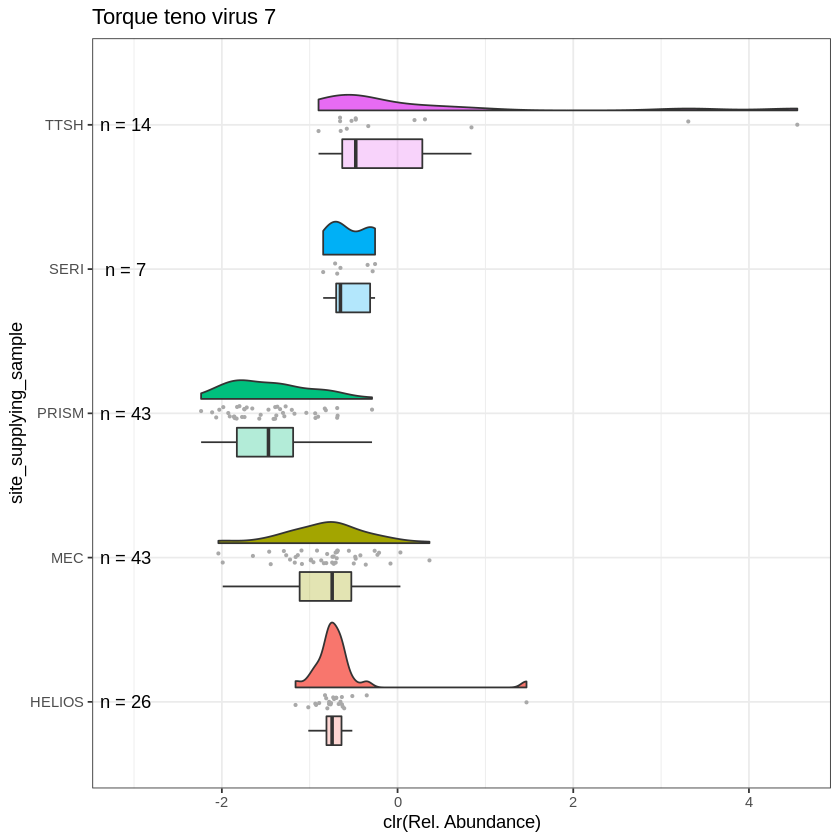

In [95]:
taxon <- "Torque teno virus 7"
column <- "site_supplying_sample"

species_long %>%
    filter(taxa == taxon, clr != 0) %>%
    ggplot(aes(x = get(column), y = clr, fill = get(column))) +
        theme_bw() +
        geom_boxplot(position = position_nudge(x = -0.2, y = 0), 
                   width = 0.2, 
                   outlier.shape = NA,
                   alpha = 0.3) +
        geom_violinhalf(position = position_nudge(x = 0.1, y = 0), alpha = 1) +
        geom_point(position = position_jitter(width = 0.05), 
                   color = "dark grey",
                     size = 0.5, 
                     alpha = 1) +
        stat_summary(fun.data = n_fun, geom = "text") +
        labs(x = "site_supplying_sample", y = "clr(Rel. Abundance)", title = taxon) +
        coord_flip() +
        theme(legend.position = "none")



### Plot batch level abundance for non-contaminants

In [11]:
get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


to_retain <- fread("data/samples_above_95_reads.txt")$npm_research_id

meta <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv") %>%
    filter(npm_research_id %in% to_retain)

meta_cols <- get_meta_cols(meta)

species_long <- species_clr %>%
    pivot_longer(where(is.numeric), names_to = "taxa", values_to = "clr") %>%
    left_join(meta %>% select(all_of(c("npm_research_id", meta_cols))))

Joining, by = "npm_research_id"



In [12]:
perc_t <- "l15h85"
file <- files[grepl(perc_t, files)]
nc <- read.csv(str_glue("{res_dir}/{file}"))$non_contaminants
length(nc)

ERROR: Error in eval(expr, envir, enclos): object 'files' not found


In [ ]:
# label_pos <- min(species_long$clr) - 0.5

# n_fun <- function(x){
#   return(data.frame(y = label_pos, label = paste0("n = ", length(x))))
# }

# for (column in meta_cols) {
#     plots_without_zeros <- foreach (taxon = nc) %dopar% {
#         species_long %>%
#     filter(taxa == taxon, clr != 0, get(column) != "Unknown") %>%
#             ggplot(aes(x = get(column), y = clr, fill = get(column))) +
#                 theme_bw() +
#                 geom_boxplot(position = position_nudge(x = -0.2, y = 0), 
#                            width = 0.2, 
#                            outlier.shape = NA,
#                            alpha = 0.3) +
#                 geom_violinhalf(position = position_nudge(x = 0.1, y = 0), alpha = 1) +
#                 geom_point(position = position_jitter(width = 0.05), 
#                            color = "dark grey",
#                              size = 0.5, 
#                              alpha = 1) +
#                 stat_summary(fun.data = n_fun, geom = "text") +
#                 labs(x = column, y = "clr(Rel. Abundance)", title = taxon) +
#                 coord_flip() +
#                 theme(legend.position = "none")
#     }


#     pdf(str_glue("results/decontamination/clr_decontamination/clr_abundance.l{perc_t}.{column}.without_zeroes.pdf"))

#         for (plt in plots_without_zeros) {
#             print(plt)
#         }

#     dev.off()
    
#     stopImplicitCluster()
# }

### t-SNE

In [ ]:
merged_RA <- species_clr %>%
    left_join(meta)

X <- merged_RA[, 1:ncol(species_clr)]
X <- X %>% select(-npm_research_id)
X_decon <- X %>% select(all_of(nc))
Y <- merged_RA[, (ncol(species_clr) + 1):ncol(merged_RA)]

# fwrite(Y, "data/temp_files_9999/07_abundance_matrix/metadata_aitchinson_matrix.clr_decon.l15h85.subset_9999.S.tsv", sep = "\t")

#### Compute Aitchinson distances for ordination
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5695134/

In [ ]:
# require(amap)
# system.time({
#     X_dist <- as.matrix(Dist(as.matrix(X), method = "euclidean", nbproc = 10))
# })

# fwrite(X_dist, "data/temp_files_9999/07_abundance_matrix/aitchinson_matrix.subset_9999.S.tsv", sep = "\t", col.names = F)
X_dist <- as.matrix(fread("data/temp_files_9999/07_abundance_matrix/aitchinson_matrix.subset_9999.S.tsv"))

In [ ]:
# system.time({
#     X_decon_dist <- as.matrix(Dist(as.matrix(X_decon), method = "euclidean", nbproc = 10))
# })

# fwrite(X_decon_dist, "data/temp_files_9999/07_abundance_matrix/aitchinson_matrix.clr_decon.l15h85.subset_9999.S.tsv", sep = "\t", col.names = F)
X_decon_dist <- as.matrix(fread("data/temp_files_9999/07_abundance_matrix/aitchinson_matrix.clr_decon.l15h85.subset_9999.S.tsv"))

#### Run t-SNE

In [ ]:
# perp <- 30
# max_iter <- 5000
# theta <- 0.5

# tsne <- Rtsne(X_dist,
#               verbose = T,
#               perplexity = perp,
#               max_iter = max_iter,
#               is_distance = T,
#               pca = T,
#               theta = theta)

# tsne_decon <- Rtsne(X_decon_dist,
#               verbose = T,
#               perplexity = perp,
#               max_iter = max_iter,
#               is_distance = T,
#               pca = T,
#               theta = theta)

#### Plot t-SNE

In [ ]:
# plot_df <- data.frame(tsne$Y, Y)
# plot_df_decon <- data.frame(tsne_decon$Y, Y)


# # Params
# size <- 2
# col <- "extraction_kit"
# # pal <- c("red", "orange", "grey")

# plt1 <- plot_df %>%
#     filter(get(col) != "Unknown") %>%
#     ggplot(aes(x = X1, y = X2, color = get(col))) +
#         geom_point(size = size, alpha = 0.3) +
# #         scale_color_manual(values = pal) +
#         theme(axis.title = element_blank(),
#               axis.text = element_blank(),
#               panel.grid.major = element_blank(),
#               panel.grid.minor = element_blank(),
#               axis.ticks = element_blank()) +
#     labs(color = col)

# plt2 <- plot_df_decon %>%
#     filter(get(col) != "Unknown") %>%
#     ggplot(aes(x = X1, y = X2, color = get(col))) +
#         geom_point(size = size, alpha = 0.3) +
# #         scale_color_manual(values = pal) +
#         theme(axis.title = element_blank(),
#               axis.text = element_blank(),
#               panel.grid.major = element_blank(),
#               panel.grid.minor = element_blank(),
#               axis.ticks = element_blank()) +
#     labs(color = col)

# combined_tsne <- ggpubr::ggarrange(plt1, plt2, ncol = 2, common.legend = T)
# ggsave(str_glue("results/decontamination/clr_decontamination/tsne_before_after.{perc_t}.png"), combined_tsne, 
#        dpi = 300,
#        height = 5, width = 10)

In [ ]:
all_genera <- colnames(species_clr)
all_genera <- all_genera[all_genera != "npm_research_id"]
head(all_genera)
length(all_genera)

### Venn diagrams

In [ ]:
# require(VennDiagram)
#     venn_list_nc <- list(non_contaminants = nc,
#                       human_associated = human_associated_nc, 
#                       kitome_associated = known_contams_nc)

#     venn_list_all <- list(all_genera = all_genera,
#                       human_associated = human_associated_all, 
#                       kitome_associated = known_contams_all)
# venn.diagram(venn_list_all, filename = "results/decontamination/clr_decontamination/all_genera_venn.png",
#              category.names = c("All genera", "Human associated", "Kitome associated"),
#              print.mode = c("raw", "percent")
#              )

# venn.diagram(venn_list_nc, filename = "results/decontamination/clr_decontamination/identified_nc_genera_venn.png",
#              category.names = c("Non-contaminants", "Human associated", "Kitome associated"),
#              print.mode = c("raw", "percent")
#              )

### Max read counts

In [ ]:
max_df <- species_df %>%
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "read_count") %>%
    group_by(taxa) %>%
    summarise(max_count = max(read_count)) %>%
    mutate(max_bins = case_when(max_count == 0 ~ "0",
                     max_count > 0 & max_count <= 10 ~ "1-10",
                     max_count > 10 & max_count <= 100 ~ "11-100",
                     max_count > 100 & max_count <= 500 ~ "101-500",
                     max_count > 500 & max_count <= 1000 ~ "501-1000",
                     max_count > 1000 & max_count <= 5000 ~ "1001-5000",
                     max_count > 5000 ~ ">5000")) %>%
    mutate(max_bins = factor(max_bins, levels = c("0", "1-10", "11-100", "101-500", "501-1000",
                                                    "1001-5000", ">5000")))


max_df %>% 
    filter(taxa %in% nc) %>%
    arrange(desc(max_count))

#### Annotate with host metadata

In [ ]:
human_regex <- paste0(known_human_pathogens, collapse = "|")
human_associated_nc <- nc[grepl(human_regex, nc)]
human_associated_all <- all_genera[grepl(human_regex, all_genera)]

max_df %>% 
    filter(taxa %in% nc) %>%
    arrange(desc(max_count)) %>%
    mutate(human_associated = ifelse(taxa %in% human_associated_all, "Yes", "No"))

In [ ]:
max_count_bar <- max_df %>% 
    filter(taxa %in% nc) %>%
    count(max_bins) %>%
    ggplot(aes(x = max_bins, y = n, fill = max_bins)) +
    geom_bar(stat = "identity") +
    labs(x = "Max read count", y = "No. of non-contaminant species") +
    theme(legend.position = "none") +
    geom_text(aes(x = 4.5, y = 40, 
                  label = str_glue("threshold = {perc_t} \n n_species = {length(nc)}")),
              hjust = 0) +
    geom_text(aes(label = n), vjust = 0)

ggsave(str_glue("results/decontamination/clr_decontamination/max_read_count_barplot.{perc_t}.png"), max_count_bar, 
       dpi = 300)

### Prevalence of non-contaminants

In [97]:
prev_t <- 10
species_prev <- species_df %>% select(-npm_research_id, -unclassified, -"Homo sapiens")
species_prev[species_prev <= prev_t] <- 0
species_prev[species_prev > prev_t] <- 1
species_prev$npm_research_id <- species_df$npm_research_id
# head(species_prev)

prev_df <- species_prev %>%
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "presence") %>%
    filter(taxa %in% nc) %>%
    group_by(taxa) %>%
    summarise(prevalence = sum(presence) / nrow(species_prev)) %>%
    arrange(desc(prevalence))

prev_df %>% filter(prevalence > 0.05)

taxa,prevalence
<chr>,<dbl>
Cutibacterium acnes,0.15822640
Ralstonia solanacearum,0.13909258
Neorhizobium galegae,0.07378552
Devosia sp. A16,0.06278643
Sinorhizobium sp. RAC02,0.06003666
Rhizobium etli,0.05900550
Gluconacetobacter diazotrophicus,0.05659945
Burkholderia multivorans,0.05419340
Aminobacter aminovorans,0.05144363


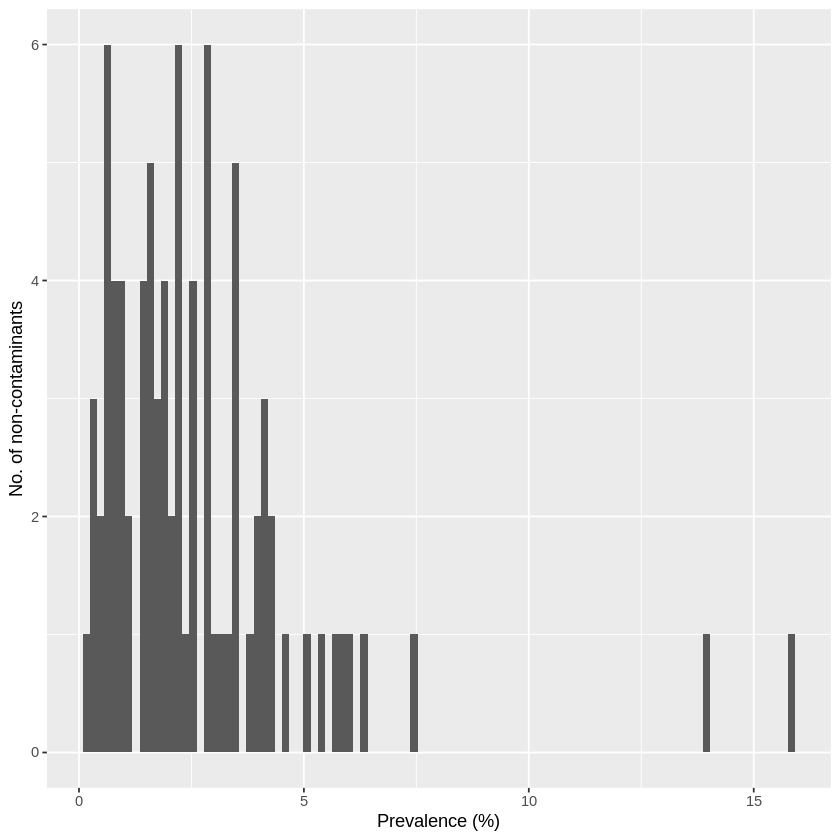

In [96]:
prev_df %>%
    ggplot(aes(x = prevalence * 100)) +
    geom_histogram(bins = 100) +
    labs(x = "Prevalence (%)", y = "No. of non-contaminants")

### Case Study: Moraxella osloensis

In [25]:
col <- "extraction_kit"
taxon <- "Moraxella osloensis"
test <- species_prev %>% 
    left_join(meta) %>%
    group_by_at(c(col)) %>%
    summarise(sum = sum(get(taxon)))

test %>% mutate(prevalence = sum / as.vector(table(meta[, ..col])))


Joining, by = "npm_research_id"



extraction_kit,sum,prevalence
<chr>,<dbl>,<dbl>
abGENIX Whole Blood Genomic DNA Extraction Kit,1002,0.4392810
"Chemagic DNA Blood Kit (Perkin Elmer, MA)",351,0.3375000
Maxwell RSC Blood DNA Kit (AS1400),1338,0.6329234
QIAamp DNA Blood Mini Kit,274,0.4228395
QIAsymphony DSP DNA Midi Kit,385,0.3989637
QIAsymphony DSP DNA Mini Kit (192),419,0.7053872
Unknown,658,0.6058932


In [83]:
read_t <- 50

for (read_t in c(0, 1, 2, 5, 10, 50, 100, 1000)) {
    overall_prev <- round(sum(species_df$`Moraxella osloensis` > read_t) / nrow(species_df) * 100, 2)

    print(str_glue("Overall prevalence (>{read_t} reads) of {taxon} = {overall_prev}%"))
}

Overall prevalence (>0 reads) of Moraxella osloensis = 50.72%
Overall prevalence (>1 reads) of Moraxella osloensis = 29.5%
Overall prevalence (>2 reads) of Moraxella osloensis = 19%
Overall prevalence (>5 reads) of Moraxella osloensis = 8.17%
Overall prevalence (>10 reads) of Moraxella osloensis = 4.09%
Overall prevalence (>50 reads) of Moraxella osloensis = 1.09%
Overall prevalence (>100 reads) of Moraxella osloensis = 0.53%
Overall prevalence (>1000 reads) of Moraxella osloensis = 0.02%


In [27]:
read_t <- 100
taxon_name <- tolower(gsub(" ", "_", taxon))
to_save <- species_df %>%
    filter(get(taxon) > read_t) %>%
    select(npm_research_id)

# fwrite(to_save, str_glue("results/decontamination/case_studies/samples_with_{taxon_name}_gt_{read_t}.txt"), col.names = F)

In [65]:
list.files("results/decontamination/case_studies/moraxella_osloensis/")

[1] "WHB1091.moraxella_osloensis.coverage.tsv"
[2] "WHH1248.moraxella_osloensis.coverage.tsv"
[3] "WHH1906.moraxella_osloensis.coverage.tsv"
[4] "WHH2170.moraxella_osloensis.coverage.tsv"
[5] "WHH4997.moraxella_osloensis.coverage.tsv"

In [66]:
samples <- c("WHB1091", "WHH1248", "WHH1906", "WHH2170", "WHH4997")

cov_list <- foreach (sample = samples) %dopar% {
    # Get no. of reads assigned
    read_meta <- species_df %>%
        filter(get(taxon) > read_t, npm_research_id == sample) %>%
        select(all_of(taxon))
    n_reads <- as.numeric(read_meta)

    # Create plot title
    plot_title <- str_glue("{sample} ({n_reads} reads assigned)")

    # Get coverage info
    cov_df <- fread(str_glue("results/decontamination/case_studies/moraxella_osloensis/{sample}.moraxella_osloensis.coverage.tsv"),
                    col.names = c("chr", "pos", "coverage")) %>%
        mutate(chr = case_when(chr == "NZ_CP014234.1" ~ "Chromosomal",
                               chr == "NZ_CP014238.1" ~ "Plsm unnamed 1",
                               chr == "NZ_CP014237.1" ~ "Plsm unnamed 2",
                               chr == "NZ_CP014236.1" ~ "Plsm unnamed 3",
                               chr == "NZ_CP014235.1" ~ "Plsm unnamed 4"
                               ))

    # Visualise coverage
    cov_df %>%
        ggplot(aes(x = pos, y = coverage, color = chr)) +
        facet_grid(cols = vars(chr)) +
        geom_line() +
        labs(x = "Position", y = "Coverage", title = plot_title) +
        theme(legend.position = "none",
              axis.text.x = element_text(angle = 45, hjust = 1))
}


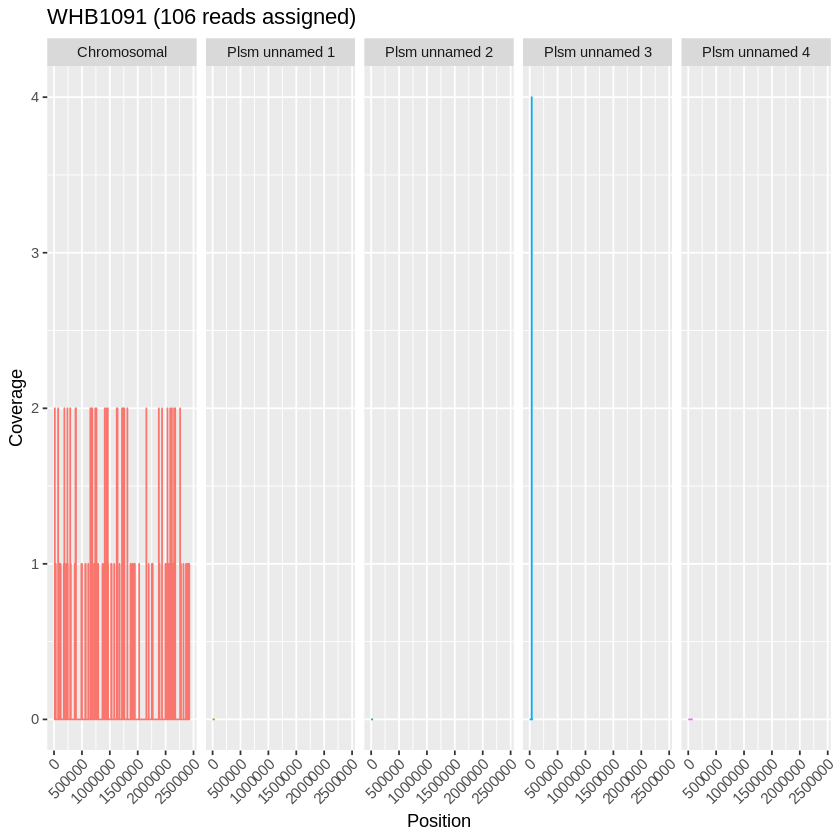

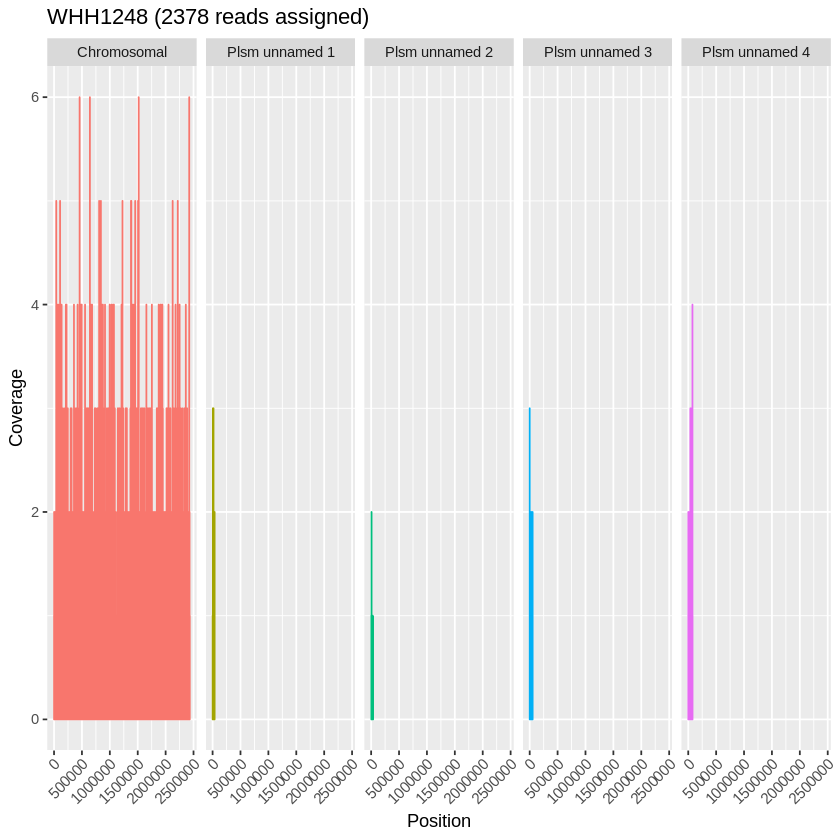

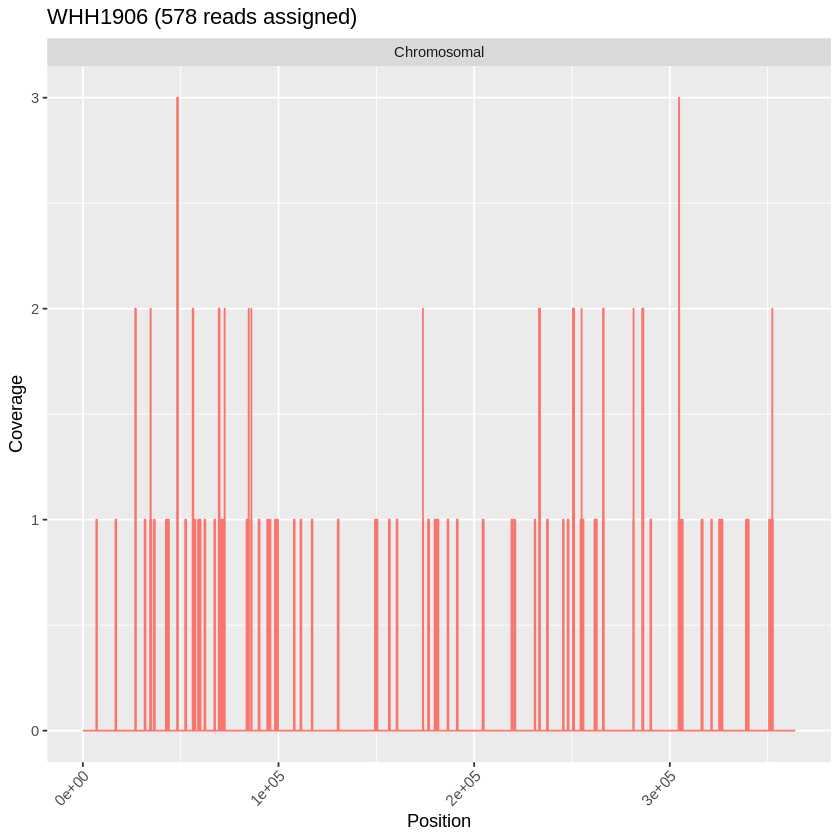

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


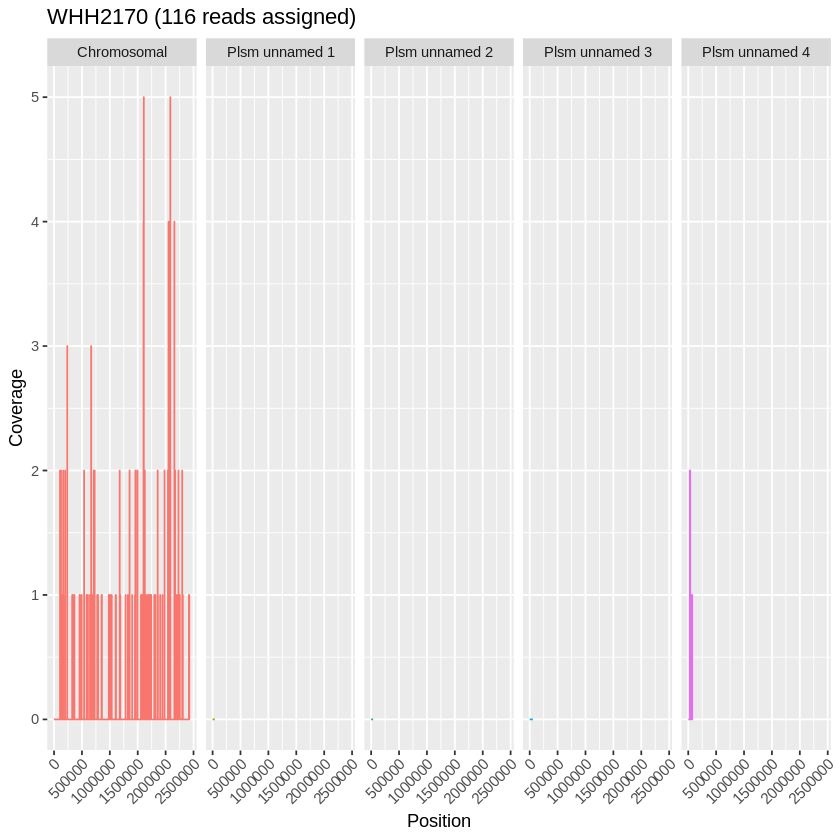

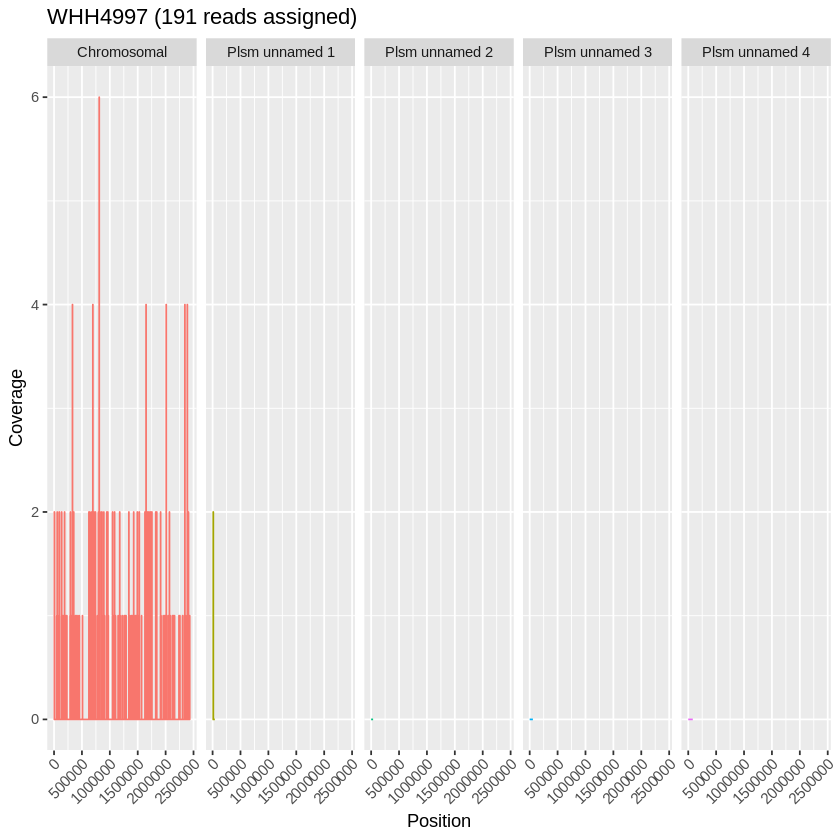

In [71]:
cov_list

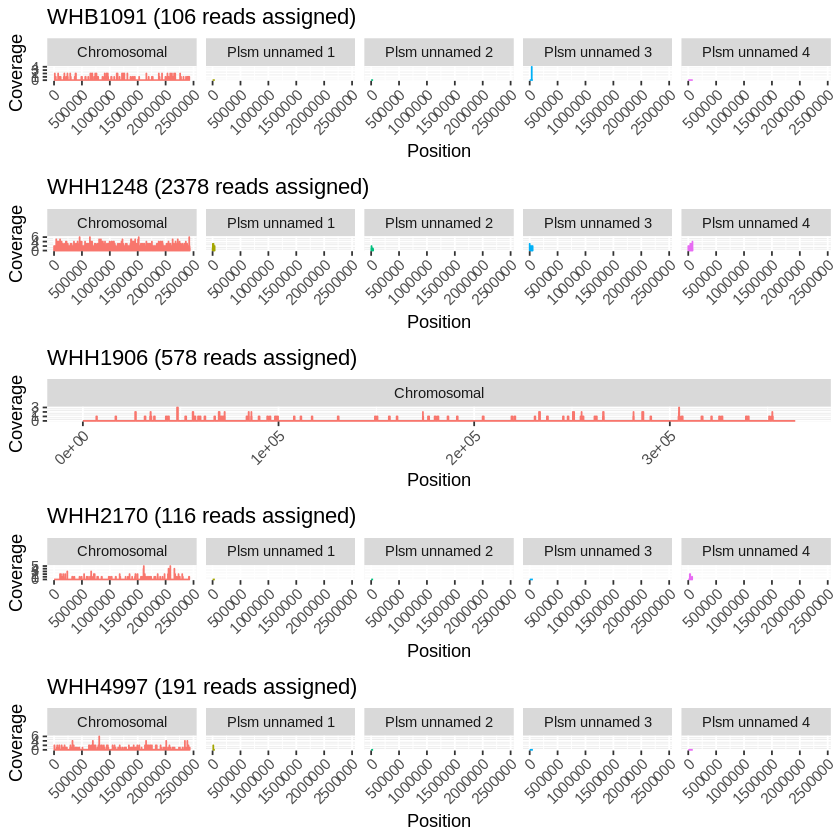

In [78]:
combined_cov <- egg::ggarrange(plots = cov_list, nrow = length(cov_list))

ggsave("results/decontamination/case_studies/moraxella_osloensis/coverage_plots.png", 
       plot = combined_cov,
       dpi = 300,
       height = 20, width = 10)


[1] "NZ_CP014234.1" "NZ_CP014238.1" "NZ_CP014237.1" "NZ_CP014236.1"
[5] "NZ_CP014235.1"

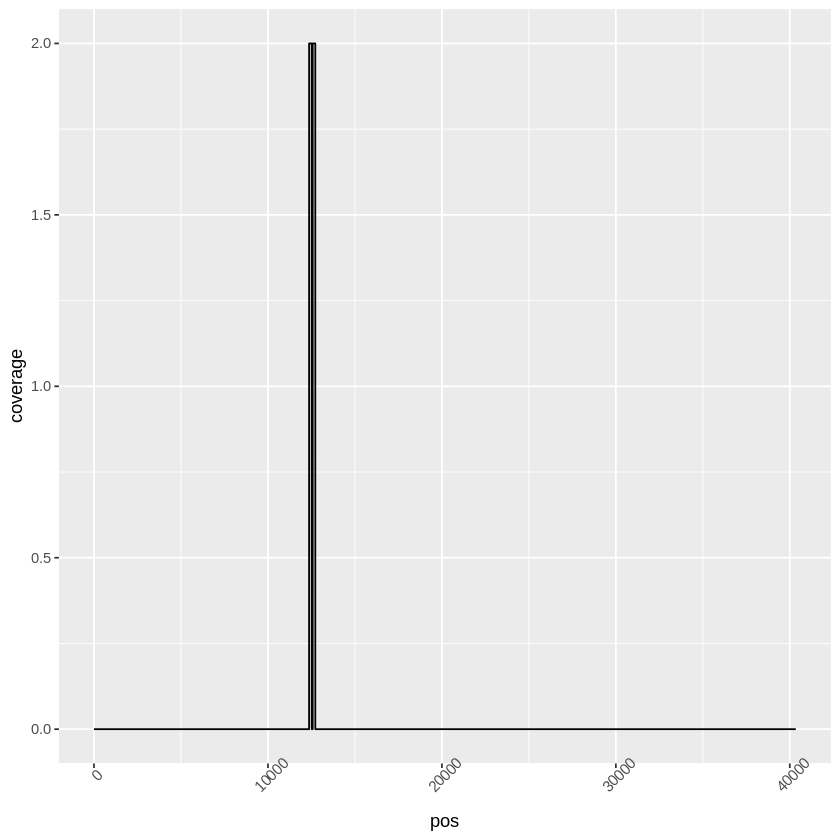

In [41]:
unique(cov_df$chr)
cov_df %>%
    filter(chr == "NZ_CP014238.1") %>%
    ggplot(aes(x = pos, y = coverage)) +
        geom_line() +
        theme(axis.text.x = element_text(angle = 45))